# Importing necessary libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Define directories for training, validation, and test data

In [ ]:

train_dir = '/kaggle/input/butterfly-images40-species/train'
validate_dir = '/kaggle/input/butterfly-images40-species/valid'
test_dir = '/kaggle/input/applai-cv-st23-assignment-3'

# Define the target image height and width for resizing
# Set the batch size for training and validation datasets
# Create data generators for training, validation, and test datasets

In [ ]:
img_height, img_width = 180, 180
batch_size = 20
train_imagenerator = keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create a data generator for the validation dataset.
# This generator rescales pixel values to the range [0, 1] for consistent processing.

In [ ]:
val_imagenerator = keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0)

# Create a data generator for the training dataset using 'train_imagenerator'.
# Loads data from the 'train_dir', resizes images to the specified dimensions,
# sets the batch size, and uses categorical labels for class_mode.

In [ ]:
train_generator = train_imagenerator.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 12594 images belonging to 100 classes.



# Create a data generator for the validation dataset using 'val_imagenerator'.
# Loads data from the 'validate_dir', resizes images to the specified dimensions,
# sets the batch size, and uses categorical labels for class_mode.

In [ ]:
val_generator = val_imagenerator.flow_from_directory(
    validate_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 500 images belonging to 100 classes.



# Visualize original images with their corresponding class labels.
# The images are obtained from the training data generator.
# The images are rescaled for display and labeled based on their class.

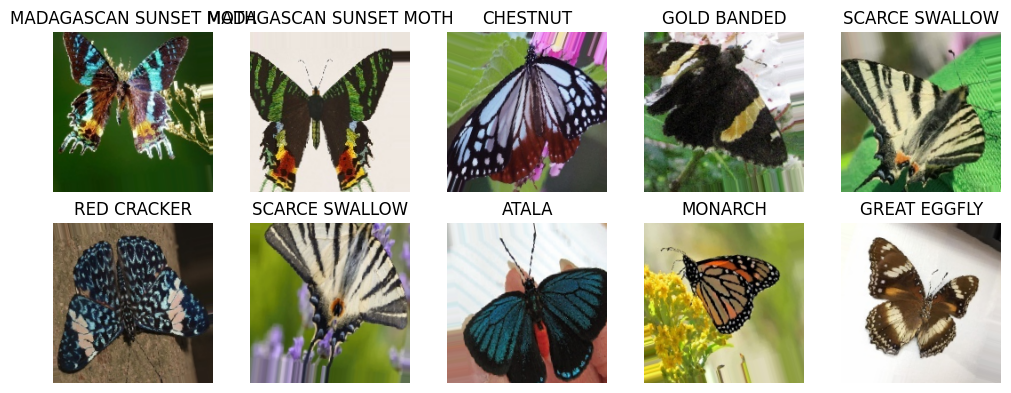

In [ ]:
import matplotlib.pyplot as plt

# Get class labels
class_labels = list(train_generator.class_indices.keys())

# Visualize original images with labels
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    # Get an image and its class label
    image, label = train_generator.next()

    # Rescale image from [0, 1] to [0, 255] for display
    image = image[0] * 255

    # Plot the image with label
    ax.imshow(image.astype('uint8'))
    ax.axis('off')

    ax.set_title(f'{class_labels[np.argmax(label)]}')

plt.tight_layout()
plt.show()

# Initialize a pre-trained InceptionResNetV2 model from Keras's applications module.
# The model is pre-trained on the ImageNet dataset and configured for feature extraction.
# It takes input images with dimensions (img_height, img_width, 3).

In [ ]:
pretrained_base_model = keras.applications.InceptionResNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(img_height, img_width, 3)
)

# Set all layers in the pre-trained InceptionResNetV2 model to non-trainable.
# This prevents these layers from being updated during the fine-tuning process.

In [ ]:
for layer in pretrained_base_model.layers:
    layer.trainable = False

# Define a new neural network model using TensorFlow/Keras.
# - Input shape: (180, 180, 3)
# - Features are extracted from the pre-trained InceptionResNetV2 model.
# - Global average pooling layer reduces spatial dimensions.
# - A dropout layer with 20% dropout rate helps prevent overfitting.
# - Output layer with 100 units and softmax activation for multi-class classification.

In [ ]:
inputs = tf.keras.Input(shape=(180, 180, 3))
x = pretrained_base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
output = tf.keras.layers.Dense(100, activation='softmax')(x)
model = tf.keras.Model(inputs, output)

# Define a learning rate schedule using an exponential decay.


In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.9
)

# Define the optimizer for model training using RMSprop with a learning rate
# Additionally, apply mixed precision training for improved numerical stability


In [ ]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule)
optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)

# Compile the neural network model:
# - Use the specified optimizer with the defined learning rate schedule.
# - Set the loss function to categorical cross-entropy for multi-class classification.
# - Specify accuracy as the evaluation metric.
# Additionally, display a summary of the model's architecture.

In [ ]:
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 inception_resnet_v2 (Functi  (None, 4, 4, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d_1   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 1536)              0         
                                                                 
 dense_1 (Dense)             (None, 100)               153700    
                                                                 
Total params: 54,490,436
Trainable params: 153,700
Non-trai

#Visualising Model architecture

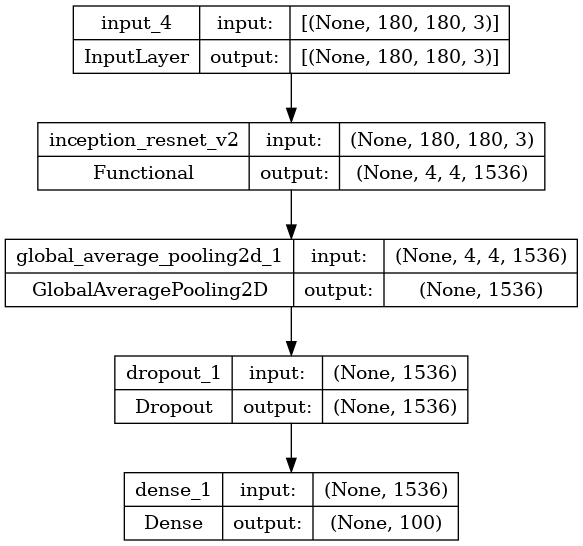

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

# Train the model using the training generator with specified steps per epoch and epochs.
# Validate the model's performance using the validation generator and steps for validation.
# This code performs model training and records training history.

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=val_generator,
    validation_steps=len(val_generator)
)

630/630 [==============================] - 125s 198ms/step - loss: 0.6416 - accuracy: 0.8424 - val_loss: 0.5768 - val_accuracy: 0.8620



# Load test data and create a data generator for it.
# The data is rescaled, and the generator is configured not to shuffle data to maintain filename order.
# Test data is prepared for predictions without class labels.

In [ ]:
# Load test data and predict
test_imagenerator = keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0)
test_generator = test_imagenerator.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,  # Keep the order of filenames
    class_mode=None  # No class labels for test data
)

Found 500 images belonging to 1 classes.


# Make predictions on the test data using the trained model.
# Extract predicted class indices from the predictions.
# Create a mapping of class indices to class labels based on the training data.
# Map predicted class indices to class labels for the test data.

In [ ]:

predictions = model.predict(test_generator, verbose=1)

predicted_class_indices = np.argmax(predictions, axis=1)

class_indices_to_labels = {v: k for k, v in train_generator.class_indices.items()}

predicted_labels = [class_indices_to_labels[idx] for idx in predicted_class_indices]

25/25 [==============================] - 6s 109ms/step


# Extract image filenames and Add "test\" prefix to image filenames


In [ ]:
# Extract image filenames
image_filenames = [os.path.basename(filename) for filename in test_generator.filenames]
image_filenames_with_prefix = ['test\\' + filename for filename in image_filenames]

# Create a DataFrame 'df' with image IDs and their corresponding predicted labels.

In [ ]:
df = pd.DataFrame({'ID': image_filenames_with_prefix, 'Prediction': predicted_labels})

# Save the DataFrame to a CSV file

In [ ]:

output_file = 'predictions.csv'
df.to_csv(output_file, index=False)